<a href="https://colab.research.google.com/github/fanbyprinciple/ML-experiments/blob/master/TMI_tabular_data_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!nvidia-smi
# ensure you use gpu

Thu Aug  4 18:21:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    26W /  70W |    876MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
from fastai import *
import pandas as pd

train = pd.read_csv("/content/TMI_DETAIL.csv")


In [22]:
#pd.set_option('display.max_rows', train.shape[0]+1)
train[:]

,TERM_YEAR,SEMESTER,ACAD_CAR_CD,ACAD_GRP_CD,ACAD_PROG_CD,GENDER_CD,ACAD_PLAN_CD,DEG_CD,STUDY_AGREEMENT_CODE,NYU_IPEDS_ETH_GRP,CNT
0,2022,Spring,BUSN,BI,BIGBI,F,BIDABCMS,MS,NaN,4,1
1,2022,Spring,BUSN,BI,BIGBI,F,BIDABCMS,MS,NaN,9,22
2,2022,Spring,BUSN,BI,BIGBI,F,BIQFINMS,MS,NaN,4,1
3,2022,Spring,BUSN,BI,BIGBI,F,BIQFINMS,MS,NaN,9,27
4,2022,Spring,BUSN,BI,BIGBI,M,BIDABCMS,MS,NaN,1,1
...,...,...,...,...,...,...,...,...,...,...,...
362693,1995,Fall,UGRD,UT,UTSOA,M,UTPHTGBFA,BFA,NaN,2,1
362694,1995,Fall,UGRD,UT,UTSOA,M,UTPHTGBFA,BFA,NaN,3,1
362695,1995,Fall,UGRD,UT,UTSOA,M,UTPHTGBFA,BFA,NaN,6,1
362696,1995,Fall,UGRD,UT,UTSOA,M,UTPHTGBFA,BFA,NaN,9,3


In [23]:
# pecularities
# 0. less number of features to predict from so highly dependent
# 1. no winter data before 2009
# 2. relatively less people join in winters 
# 3. most people join during spring and fall - these can be put together
# 4. around 25k people join in summer - can be put into different category

# things we can try - we can devide the dataset based on category and year
# and have different models for all of them

# trying with fastai
from fastai.tabular.all import * 
from fastai.test_utils import show_install

show_install()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



```text
=== Software === 
python        : 3.7.13
fastai        : 2.7.7
fastcore      : 1.5.13
fastprogress  : 1.0.3
torch         : 1.12.0+cu113
nvidia driver : 460.32
torch cuda    : 11.3 / is available
torch cudnn   : 8302 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : Tesla T4

=== Environment === 
platform      : Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Sun Apr 24 10:03:06 PDT 2022
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/content
/env/python
/usr/lib/python37.zip
/usr/lib/python3.7
/usr/lib/python3.7/lib-dynload
/usr/local/lib/python3.7/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.7/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
O

In [24]:
train_df = train

# for test lets use sklearn train test split
from sklearn.model_selection import train_test_split
X = train.drop(["CNT"],axis=1)
y = train["CNT"]
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# we will only take for test data and train on all

test_df = X_test
test_df["CNT"] = y_test

test_df.head()


,TERM_YEAR,SEMESTER,ACAD_CAR_CD,ACAD_GRP_CD,ACAD_PROG_CD,GENDER_CD,ACAD_PLAN_CD,DEG_CD,STUDY_AGREEMENT_CODE,NYU_IPEDS_ETH_GRP,CNT
60217,2019,Spring,UGRD,UT,UTSOA,M,UTREMUBFA,BFA,GLOBAL-0D,1,4
294366,2002,Fall,UGRD,UA,UARTS,F,UACHEMBA,BA,NaN,4,14
156872,2013,Winter,UGRD,SU,SUABU,F,SULBS,-,NaN,9,1
336336,1998,Spring,UGRD,DC,DCSCP,M,DCBLDGDIPL,DIPL,NaN,4,1
269395,2004,Summer,GRAD,GE,GEEDU,F,GEHONDMS,MS,NaN,4,9


In [25]:
# looking for null entries and na
train_df.isna().sum().sum(), test_df.isna().sum().sum(), train_df.isnull().sum().sum(), test_df.isnull().sum().sum()

(314939, 63135, 314939, 63135)

In [26]:
train_df.head()

,TERM_YEAR,SEMESTER,ACAD_CAR_CD,ACAD_GRP_CD,ACAD_PROG_CD,GENDER_CD,ACAD_PLAN_CD,DEG_CD,STUDY_AGREEMENT_CODE,NYU_IPEDS_ETH_GRP,CNT
0,2022,Spring,BUSN,BI,BIGBI,F,BIDABCMS,MS,NaN,4,1
1,2022,Spring,BUSN,BI,BIGBI,F,BIDABCMS,MS,NaN,9,22
2,2022,Spring,BUSN,BI,BIGBI,F,BIQFINMS,MS,NaN,4,1
3,2022,Spring,BUSN,BI,BIGBI,F,BIQFINMS,MS,NaN,9,27
4,2022,Spring,BUSN,BI,BIGBI,M,BIDABCMS,MS,NaN,1,1


In [27]:
# The column 'num_sold' is our depended variable. For numerical reasons the logarithmic value is usefull. 
# The value range of the depended variables is needed to build the tabular learner later on. Setting the range will add a sigmoid function at the last output.
dep_var = ['CNT']
train_df[dep_var] = np.log(train_df[dep_var])
max_dep_value = np.max(train_df[dep_var].max()) * 1.05
min_dep_value = np.min(train_df[dep_var].min()) * 0.95
dep_value_range = torch.tensor([min_dep_value, max_dep_value], device=device)
dep_value_range, dep_var


(tensor([0.0000, 9.3114], device='cuda:0', dtype=torch.float64), ['CNT'])

In [28]:
# looking at unique entries
np.unique(train_df['TERM_YEAR'], return_counts=True), np.unique(train_df['SEMESTER'], return_counts=True)

# there seems to variable number of entries with respect to the years 
# and seasons

((array([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
         2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
         2017, 2018, 2019, 2020, 2021, 2022]),
  array([ 3611,  9374,  9710, 10265, 10556, 10421, 10645, 10821, 10969,
         11190, 11215, 11532, 12021, 11908, 12447, 13399, 14486, 14622,
         15280, 16225, 17195, 17615, 17992, 18207, 18768, 17648, 17081,
          7495])),
 (array(['Fall', 'Spring', 'Summer', 'Winter'], dtype=object),
  array([133660, 137018,  82578,   9442])))

In [29]:
#cut = train_df['date'][(train_df['date'] == train_df['date'][len(test_df)])].index.max()
# ill use simpler way to use cut

cut = len(train_df) - int(0.8 * len(train_df))
print(cut)
train_idx = range(len(train_df)-cut-1)
valid_idx = range(len(train_df)-cut, len(train_df)-1)
splits = (list(train_idx),list(valid_idx))
train_idx, valid_idx

72540


(range(0, 290157), range(290158, 362697))

In [30]:
#  deviding into cont and categorical data
cont_vars, cat_vars = cont_cat_split(train_df, dep_var= dep_var,  max_card=12)
cat_vars, cont_vars

# NYU_IPEDS_ETH_GRP is the only categorical variable

(['SEMESTER',
  'ACAD_CAR_CD',
  'ACAD_GRP_CD',
  'ACAD_PROG_CD',
  'GENDER_CD',
  'ACAD_PLAN_CD',
  'DEG_CD',
  'STUDY_AGREEMENT_CODE',
  'NYU_IPEDS_ETH_GRP'],
 ['TERM_YEAR'])

In [31]:
procs=[Categorify, FillMissing, Normalize]
to_train = TabularPandas(train_df, 
                         procs=procs, 
                         cat_names=cat_vars, 
                         cont_names=cont_vars, 
                         splits=splits,
                         device=device,
                         y_names=dep_var,
                         y_block=RegressionBlock())

# not using any custom splits here

In [32]:
# train dataloaders

dls = to_train.dataloaders(bs=8) # incredibly low batch size
len(dls.train),len(dls.valid), type(dls.train), dls.train.device



(36269, 9068, fastai.tabular.core.TabDataLoader, device(type='cuda', index=0))

In [33]:
# using smape for function to have a custom loss : 
# https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error



def smape(y_pred, target):
    return torch.mean(2*torch.abs(y_pred - target)/(torch.abs(target) + torch.abs(y_pred)))



class MyLoss(nn.Module):
    def __init__(self, diff_weight=0.5):
        super().__init__()
        self.diff_weight = diff_weight
        
    def forward(self,y_pred, target):
        num_loss =  (1-self.diff_weight) * smape(y_pred[:,0], target[:,0])
        diff_loss = self.diff_weight * smape(y_pred[:,1], target[:,1])
        return num_loss + diff_loss    

In [34]:
my_config = tabular_config(ps=.15, embed_p=0.15, use_bn=True, y_range=dep_value_range)

learn = tabular_learner(dls, 
                        n_out = dls.c,
                        config = my_config,
                        layers = [64,256,1024,1024,256,64,16],
                        metrics = [smape, exp_rmspe]) 
                       
learn.summary()


TabularModel (Input shape: 8 x 9)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 4               
Embedding                                 20         True      
____________________________________________________________________________
                     8 x 6               
Embedding                                 66         True      
____________________________________________________________________________
                     8 x 15              
Embedding                                 840        True      
____________________________________________________________________________
                     8 x 30              
Embedding                                 5670       True      
____________________________________________________________________________
                     8 x 3               
Embedding                                 9          True      
________________________________________________________________

SuggestedLRs(valley=0.02754228748381138)

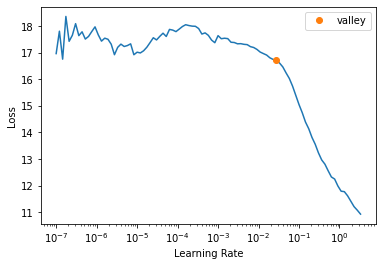

In [35]:
# finding a learning rate

learn.lr_find()

In [ ]:
learn.fit_one_cycle(30, 3e-3)

epoch,train_loss,valid_loss,smape,_exp_rmspe,time
0,0.859635,0.916310,1.051421,1.284475,08:41
1,0.829182,0.876344,1.056174,1.065944,08:21


In [ ]:
# there is some generator trouble probably because of 
# 1. lack of split
# 2. batch size is less


learn.show_results(shuffle=False)

In [ ]:
# predictions

dlt = learn.dls.test_dl(test_df, bs=64) 
nn_preds, _ = learn.get_preds(dl=dlt) 
nn_preds.min(), nn_preds.max()


# the value we are getting is auto normalised score. (exp)

In [ ]:
np.exp(nn_preds) # actual result from test df

In [ ]:
test_df["CNT"] # the actual values

In [ ]:
new_preds = test_df

new_preds["nn_preds"] = np.exp(nn_preds)

new_preds

In [ ]:
# maybe we can try with the error function you used to check

from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(new_preds['CNT'], np.exp(nn_preds)))
print('Mean Squared Error:', metrics.mean_squared_error(new_preds['CNT'], np.exp(nn_preds)))
print('Root Mean Squared Error:', np.sqrt(
                                          metrics.mean_squared_error(new_preds['CNT'], np.exp(nn_preds))
                                         ))

# woah! why this is too much!

In [36]:
# i dont think there is much accuracy imporvement because of disparate dataset
# instead we can try other options I mentioned before.

# pecularities
# 0. less number of features to predict from so highly dependent
# 1. no winter data before 2009
# 2. relatively less people join in winters 
# 3. most people join during spring and fall - these can be put together
# 4. around 25k people join in summer - can be put into different category

# things we can try - we can devide the dataset based on category and year
# and have different models for all of them
